In [7]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor, early_stopping
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv("data/processed/processed_v1.csv", low_memory=False)
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')

In [4]:
X = df.drop('Sales Price', axis=1)
y = df['Sales Price']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
lgbm_model = LGBMRegressor(
    n_estimators=10000,
    learning_rate=0.05,
    n_jobs=-1,
    random_state=42
)

lgbm_model.fit(
    X_train, 
    y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='mse',  
    callbacks=[early_stopping(100)] 
)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5362
[LightGBM] [Info] Number of data points in the train set: 330158, number of used features: 44
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 10.105867
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[6479]	valid_0's l2: 0.0404501


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,10000
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


Mean Absolute Error (in Dollars): $4,311.64 in % of the price: 13.81%
Successfully saved 'lgbm_loss_curve.png'


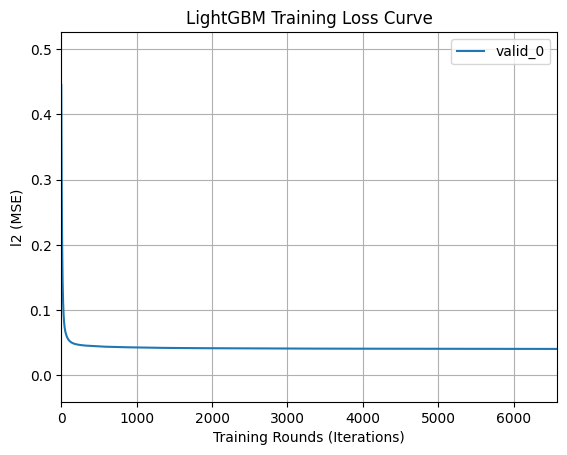

In [15]:
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

log_preds = lgbm_model.predict(X_val)
final_y_val = np.expm1(y_val)
final_preds = np.expm1(log_preds)

# 4. Calculate Mean Absolute Error on the REAL prices
dollar_mae = mean_absolute_error(final_y_val, final_preds)

print(f"Mean Absolute Error (in Dollars): ${dollar_mae:,.2f} in % of the price: {100 * dollar_mae / final_y_val.mean():.2f}%")

lgb.plot_metric(lgbm_model, metric='l2')
plt.title('LightGBM Training Loss Curve')
plt.xlabel('Training Rounds (Iterations)')
plt.ylabel('l2 (MSE)')
print("Successfully saved 'lgbm_loss_curve.png'")

--- Generating Feature Importance Plot ---
Successfully saved 'lgbm_feature_importance.png'


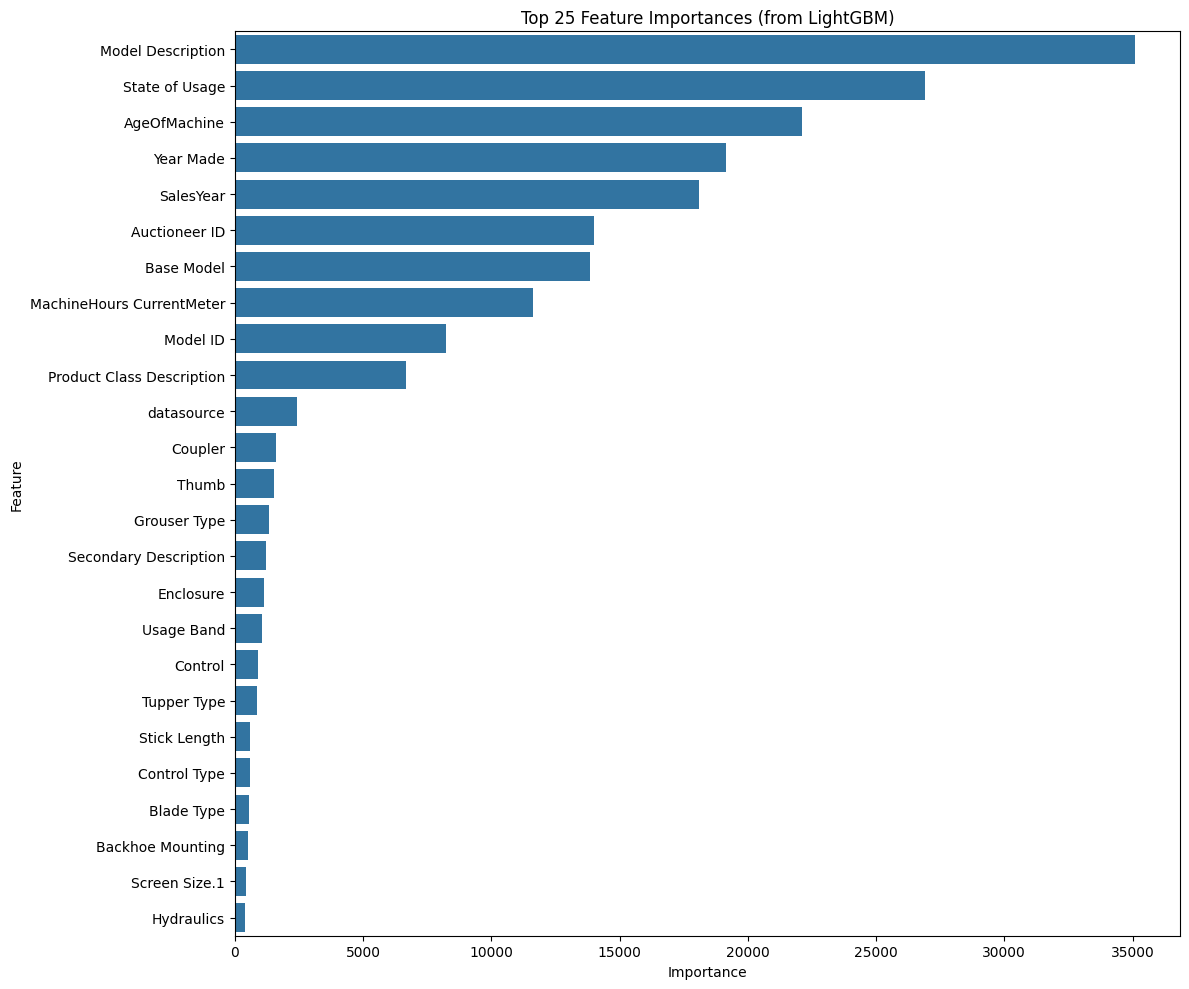

In [ ]:
import seaborn as sns

# Assuming 'lgbm_model' is your trained LightGBM model
# and 'X_train' is your training feature DataFrame

print("--- Generating Feature Importance Plot ---")

try:
    # Get feature importances
    importances = lgbm_model.feature_importances_
    feature_names = X_train.columns

    # Create a DataFrame for easy sorting and plotting
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })

    # Sort by importance (most important first)
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # --- Plot the Top 25 Most Important Features ---
    plt.figure(figsize=(12, 10))
    sns.barplot(
        x='Importance',
        y='Feature',
        data=importance_df.head(25) # Plot the top 25
    )
    plt.title('Top 25 Feature Importances (from LightGBM)')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    
    plt.savefig('lgbm_feature_importance.png')
    print("Successfully saved 'lgbm_feature_importance.png'")

except Exception as e:
    print(f"An error occurred while plotting feature importance: {e}")